<a href="https://colab.research.google.com/github/Topolewski-Kamil/dKnn/blob/main/base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
model_str = ''
neihbours_nnd_index = ''
adv_ex = ''
neihbours_nnd = ''
neihbours_lsh = ''

# model_str = 'a'
# neihbours_nnd_index = 'a'
# adv_ex = 'a'
# neihbours_nnd = 'a'
# neihbours_lsh = 'a'

process_knn1 = False
process_adv1 = False
process_act1 = False

# compute2 = False

Mount drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/disseration

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/disseration


Import modules

In [3]:
%tensorflow_version 2.x

import numpy as np
import string
import os
from bisect import bisect_left
import pickle

import keras
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import backend as K
from keras.models import load_model
from keras.losses import MSE
from keras.models import Sequential
from keras.layers import Conv2D, Lambda, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.utils.np_utils import to_categorical

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# approximate nearest neighbours libraries
!pip install pynndescent
!pip install falconn
!pip install annoy
!pip install faiss-gpu

import faiss
import pynndescent
import falconn
import annoy

Mnist dataset

In [4]:
num_classes = 10
input_shape = (28, 28, 1)

# import mnist data
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale to [0, 1] size
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Make images shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# keep raw labels in separate array
y_test_raw = y_test[750:10000]
y_train_raw = y_train
y_cal_raw = y_test[0:750]

# convert labels to one hot enconding
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# split test set into calibration set
x_cal = x_test[0:750] 
y_cal = y_test[0:750]
x_test = x_test[750:10000]
y_test = y_test[750:10000]

# x_cal = x_test[0:750] 
# y_cal = y_test[0:750]
# x_test = x_test[750:10000]
# y_test = y_test[750:10000]

Initialize CNN model

In [5]:
if process_knn1:
  model = keras.Sequential(
      [
          keras.Input(shape=input_shape),
          layers.Conv2D(64, kernel_size=(8, 8), strides=(2,2), padding='same', activation='relu', input_shape=x_train.shape[1:]),
          layers.Conv2D(128, kernel_size=(6, 6), strides=(2,2), padding='valid', activation='relu'),
          layers.Conv2D(128, kernel_size=(5, 5), strides=(1,1), padding='valid', activation='relu'),
          layers.Flatten(),
          layers.Dropout(0.5),
          layers.Dense(10, activation=tf.nn.softmax),
      ]
  )

  batch_size = 500
  epochs = 8

  adam_opt = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(loss="categorical_crossentropy", optimizer=adam_opt, metrics=["accuracy"])
  # model.summary()
  neighbours_layers_indexes = [0,1,2]
  knn_layers_count = len(neighbours_layers_indexes)

Train model


In [6]:
if process_knn1:
  # try loading model from files
  try:
    model = load_model(model_str + 'deepKNN_model_new.h5')
    print("loaded model from disc")

  # otherwise train from scratch
  except OSError:
    print("failed to load model from disc")
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)
    # model.save('deepKNN_model_new.h5')  # creates a HDF5 file
    print("saved model successfully")
    
  score = model.evaluate(x_test, y_test, verbose=0)
  print("Test accuracy:", score[1])

Evaluate model

Generate Adversarial Examples

In [7]:
def generate_image_adversary(model, image, label, eps):

  # Make images shape (1, 28, 28, 1)
  image = tf.cast(image.reshape(1, 28, 28, 1), tf.float32)

  # record our gradients
  with tf.GradientTape() as tape:

    # start tracing image by the Tape
    tape.watch(image)

    #compute prediction
    pred = model(image)

    # compute loss
    loss = MSE(label, pred)

    # calculate the gradient of loss function 
    grad = tape.gradient(loss, image)

    # compute the sign of the gradient
    sign = tf.sign(grad)

    # create perturbation
    perturbation = sign * eps

    # apply perturbation to image
    adversary = (image + perturbation).numpy()

    # Make images shape (28, 28, 1)
    adversary = adversary.reshape(28, 28, 1)
    
    return adversary

In [8]:
def load_adversarial(folder):
  adversaries = {}
  for eps in epsilons:
    eps_str = str(eps)
    eps_str = eps_str.translate(str.maketrans('', '', string.punctuation))
    path = folder + 'adv_datasets/adversaries' + eps_str + adv_ex + '.npy'
    adversaries[eps] = np.load(path)
  return adversaries

def save_adversarial(adversaries, folder):
  for eps in epsilons:
    eps_str = str(eps)
    eps_str = eps_str.translate(str.maketrans('', '', string.punctuation))
    filename = folder + 'adv_datasets/adversaries' + eps_str + '.npy'
    np.save(filename, adversaries[eps])
    print('saved ' + str(eps))

In [9]:
if process_adv1:
  epsilons = [0.025, 0.05, 0.075, 0.1, 0.125, 0.15]
  try:
    fgsm_adversarials = load_adversarial('')
    epsilons.insert(0, 0.0)
    fgsm_adversarials[0.0] = x_test
    print('loaded adversarial datasets from disc')
  except FileNotFoundError:
    print('failed to load adversarial datasets from disc')
    fgsm_adversarials = {}
    for eps in epsilons:
      adv = []
      for i in range(x_test.shape[0]):
        adv.append(generate_image_adversary(model, x_test[i], y_test[i], eps))
      fgsm_adversarials[eps] = np.array(adv)
      # save_adversarial(fgsm_adversarials, '')
    epsilons.insert(0, 0.0)
    fgsm_adversarials[0.0] = x_test

Test model on adversarial attacks

In [10]:
def plot_accuracy_vs_epsilon(model, fgsm_adversarials):
  accuracies_plot = []
  for eps in epsilons:
    adversary_score = model.evaluate(fgsm_adversarials[eps], y_test, verbose=0)
    accuracies_plot.append(adversary_score[1] * 100)
    print(adversary_score)

  plt.figure(figsize=(5,5))
  plt.plot(epsilons, accuracies_plot, linestyle='--', marker='o', color='b', label = 'DNN')

  plt.yticks(np.arange(0, 101, step=10))
  plt.xticks(np.arange(0, 0.16, step=0.025))
  plt.xlabel("Epsilon")
  plt.ylabel("Accuracy")
  plt.title("Accuracy vs Epsilon")
  plt.legend()

if process_adv1:
  plot_accuracy_vs_epsilon(model, fgsm_adversarials)
  plt.show()

Plot some adversarial examples

In [11]:
def plot_adv_examples():
  counter = 0
  plt.figure(figsize=(10,15))

  for eps in epsilons:
    adv_img = fgsm_adversarials[eps][10:15]
    true_label = y_test[10:15]

    adv_results = model.predict(fgsm_adversarials[eps][10:15])
    predicted_labels = []
    for result in adv_results:
      predicted_labels.append(np.argmax(result))

    for i in range(5):
        counter += 1
        plt.subplot(len(epsilons), 5, counter)
        plt.xticks([], [])
        plt.yticks([], [])

        if i == 0:
          plt.ylabel('Eps: '+ str(eps), fontsize=14)

        label = np.argmax(true_label[i])
        if predicted_labels[i] != label:
          incorrect_label = plt.title('Pred. label: ' + str(predicted_labels[i]))
          plt.setp(incorrect_label, color='r')
        else:
          if eps == 0.0:
            plt.title(r"$\bf{" + 'True label:' + str(label) + "}$" + '\n\nPred. label:' + str(predicted_labels[i]))
          else:
            plt.title('Pred. label: ' + str(predicted_labels[i]))

        plt.imshow(np.squeeze(adv_img[i]), cmap="gray")
  plt.savefig('adv_examples.png')
  plt.show()

# plot_adv_examples()

Functions for saving and loading precalulated neighbours

In [12]:
def save_pickle(save_object, filename):
  with open(filename, 'wb') as f:
    pickle.dump(save_object, f)

def load_pickle(filename):
  with open(filename, 'rb') as f:
    loaded_object = pickle.load(f)
    return loaded_object

Function getting activations on each layer

In [13]:
def get_activations(model, dataset, neighbours_layers_indexes):
    reshaped_output_layer = []
    for i in neighbours_layers_indexes: # 0,1,2-convolutions layer, 5-dense layer
        layer = model.layers[i]
        lay_act = K.function([model.layers[0].input], [layer.output])([dataset])[0]
        if i != 4:
          reshaped_output_layer.append(lay_act.reshape(lay_act.shape[0], lay_act.shape[1]*lay_act.shape[2]*lay_act.shape[3]))
        else: 
          reshaped_output_layer.append(lay_act)
    
    for layer in reshaped_output_layer:
        layer /= np.linalg.norm(layer, axis=1).reshape(-1, 1)

    return reshaped_output_layer

Index trainingset knn

In [14]:
if process_act1:
  activations_train = get_activations(model, x_train, neighbours_layers_indexes)

def index_layer(activations_train):
  index_act = pynndescent.NNDescent(activations_train) # index training data
  index_act.prepare() # prepare for faster query
  return index_act

if process_knn1:
  try: 
    index_act = load_pickle(neihbours_nnd_index + 'neighbours_index_new.pkl')
    print('loaded neighbours index from disc')
  except FileNotFoundError:
    print('failed to load neighbours index from disc')
    index_act = {}
    for layer in range (knn_layers_count):
      index_act[layer] = index_layer(activations_train[layer])
    # save_pickle(index_act, 'neighbours_index_new.pkl')

Find Neigbours on each layer of training data

In [15]:
# get activations of test set on each layer
if process_act1:
  activations = {}
  for eps in epsilons:
    activations[eps] = get_activations(model, fgsm_adversarials[eps], neighbours_layers_indexes)

k_neighbours = 75
def find_neighbours(activations, index, knn_eps):
  neighbors = index.query(activations, k=k_neighbours, epsilon=knn_eps)
  neighbors_labels = y_train_raw[neighbors[0]]
  return neighbors_labels
  
if process_knn1:
  try:
    neighbors = load_pickle(neihbours_nnd + 'neighbours_new.pkl')
    print('loaded neighbours from disc')
  except FileNotFoundError:
    print('failed to load neighbours from disc')
    neighbors = {}
    for layer in range (knn_layers_count):
      neighbors[layer] = {}
      for eps in epsilons:
        neighbors[layer][eps] = find_neighbours(activations[eps][layer], index_act[layer], 0.1)
    # save_pickle(neighbors, 'neighbours_new.pkl')

Calculate correct neighbours

In [16]:
def correct_neighbours_count(neihgbours):
  correct_neighbours = [0] * (k_neighbours + 1)
  for i in range(0, neihgbours.shape[0]):
    correct = np.sum(neihgbours[i] == y_test_raw[i])
    correct_neighbours[correct] += 1
  return correct_neighbours

def compare_neigbours(neighbours, layer, eps):
  plt.figure(figsize=(15,5))
  x_ax = np.arange(len(neighbours[layer][0.0]))
  plt.bar(x_ax-0.2, neighbours[layer][0.0], 0.4, label = 'Epsilon: 0.0')
  plt.bar(x_ax+0.2, neighbours[layer][eps], 0.4, label = 'Epsilon: ' + str(eps))

  plt.xlabel("Neigbours")
  plt.ylabel("Number of correct neigbours")
  plt.title("Number of correct neigbours on layer number: " + str(layer+1))
  plt.legend()

  plt.xticks(x_ax);
  plt.show() 

if process_knn1:
  correct_neighbours = {}
  for layer in range (knn_layers_count):
    correct_neighbours[layer] = {}
    for eps in epsilons:
      correct_neighbours[layer][eps] = correct_neighbours_count(neighbors[layer][eps])

  compare_neigbours(correct_neighbours, 0, 0.15)

Calibration set

In [17]:
if process_act1:
  activations_calib = get_activations(model, x_cal, neighbours_layers_indexes)

if process_knn1:
  neigbours_calib = {}
  for layer in range (knn_layers_count):
    neigbours_calib[layer] = find_neighbours(activations_calib[layer], index_act[layer], 0.1)

# Returns how many neighbours does not match real label
def count_not_matching_labels(neihgbours_arr):
  nonconformity = []
  for i in range(0, neihgbours_arr.shape[0]):
    incorrect = np.sum(neihgbours_arr[i] != y_cal_raw[i])
    nonconformity.append(incorrect)

  return np.array(nonconformity)

def calibrate_nonconformity(neigbours_calib, knn_layers_count):
  nonconformity_calib = np.zeros(neigbours_calib[0].shape[0])
  for layer in range(knn_layers_count):
    nonconformity_calib += count_not_matching_labels(neigbours_calib[layer])
  # sort
  nonconformity_calib =  np.sort(nonconformity_calib)
  # trim zeros
  nonconformity_calib = np.trim_zeros(nonconformity_calib, trim='f')

  return nonconformity_calib

if process_knn1:
  nonconformity_calib = calibrate_nonconformity(neigbours_calib, knn_layers_count)

Calculate p-values, credibility and predicted labels

In [18]:
# calculate_nonconformity for each class based on calibration
def calculate_nonconformity(eps, neighbors, knn_layers_count):
  nonconformity_for_class = np.full((x_test.shape[0], num_classes), k_neighbours * knn_layers_count, dtype=np.float32)
  for i in range(x_test.shape[0]):
    for layer in range(knn_layers_count):
      for neighbour in neighbors[layer][eps][i]:
        nonconformity_for_class[i][neighbour] -= 1

  return nonconformity_for_class

def calculate_p_values(nonconformity_for_class, nonconformity):
  p_values = np.empty((x_test.shape[0], num_classes),  dtype=np.float32)
  for i in range(x_test.shape[0]):
    for j in range(num_classes):
      insert_index = bisect_left(nonconformity, nonconformity_for_class[i][j])
      p_values[i][j] = (nonconformity.shape[0] - insert_index) / nonconformity.shape[0]
  return p_values

def predict_labels(eps, nonconformity_for_class):
  knn_predicted_labels = []
  for i in range(x_test.shape[0]):
    knn_predicted_labels.append(np.argmin(nonconformity_for_class[eps][i]))
  return np.array(knn_predicted_labels)

def calculate_performance_parameters(neighbors, nonconformity_calib, knn_layers_count):
  nonconformity_for_class = {}
  p_values = {}
  knn_predicted_labels = {}
  for eps in epsilons:
    nonconformity_for_class[eps] = calculate_nonconformity(eps, neighbors, knn_layers_count)
    p_values[eps] = calculate_p_values(nonconformity_for_class[eps], nonconformity_calib)
    knn_predicted_labels[eps] = predict_labels(eps, nonconformity_for_class)
  return p_values, knn_predicted_labels

  
if process_knn1:
  p_values, knn_predicted_labels = calculate_performance_parameters(neighbors, nonconformity_calib, knn_layers_count)

Plot performance in respect to credibility

In [19]:
def calculate_performance_per_cred(confidence, predicted_labels):
  credibility = np.max(confidence, axis=1)
  distribution = np.zeros(10)
  correct_labels = np.zeros(10)

  for i in range(credibility.shape[0]):
    bin = credibility[i] // 0.1 / 10
    bin_index = int(bin*10)
    distribution[bin_index] += 1
    if (predicted_labels[i] == y_test_raw[i]):
      correct_labels[bin_index] += 1

  for i in range(correct_labels.shape[0]):
    if correct_labels[i] != 0 and distribution[i] != 0:
      correct_labels[i] /=  distribution[i]

  return distribution, correct_labels 

def plot_reliability(model_type, eps, confidence, predicted_labels):

    if model_type == 'Softmax':
      softmax_probabilities = model.predict(fgsm_adversarials[eps])
      softmax_classes = softmax_probabilities.argmax(axis=-1)
      confidence = softmax_probabilities
      num_points, reliability_diag = calculate_performance_per_cred(confidence, softmax_classes)
    else:
      num_points, reliability_diag = calculate_performance_per_cred(confidence, predicted_labels)


    bars_begin = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    bars_end = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    bars_center = [0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]

    fig, ax1 = plt.subplots()
    ax1.bar(bars_center, reliability_diag, width=.1, alpha=0.8, edgecolor = "black")
    ax1.set_ylim([0, 1.])

    ax2 = ax1.twinx()
    ax2.plot(bars_center, num_points, color='r', linestyle='-', linewidth=6.0)

    plt.title("Reliability Diagram: " + model_type + ', eps: ' + str(eps))
    ax2.set_ylabel('Number of points in dataset', color='r')
    ax1.set_xlabel('Prediction Credibility')
    ax1.set_ylabel('Prediction Accuracy')
    ax2.tick_params(colors='r')
    plt.show()

In [20]:
if process_knn1:
  # plot_reliability('Softmax', eps = 0.15, None, None)
  plot_reliability('DkNN', 0.15, p_values[0.15], knn_predicted_labels[0.15])

No handles with labels found to put in legend.


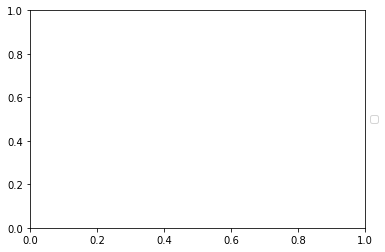

In [21]:
def test_model_accuracy(labels1, labels2):
  correct_labels = np.sum(labels1 == labels2)
  return correct_labels / labels1.shape[0] * 100

def accuracy_per_model(knn_predicted_labels):
  accuracies_plot_knn = []
  for eps in epsilons:
    model_accuracy = test_model_accuracy(knn_predicted_labels[eps], y_test_raw)
    accuracies_plot_knn.append(model_accuracy)
  return accuracies_plot_knn

lgd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('lsh_graph', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

if process_knn1:
  accuracies_plot_knn = accuracy_per_model(knn_predicted_labels)
  plot_accuracy_vs_epsilon(model, fgsm_adversarials)
  plt.plot(epsilons, accuracies_plot_knn, linestyle='--', marker='^', color='r', label = 'DkNN - NND')
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.show()

# Faiss

In [ ]:
# neighbours_index_faiss = {}
# dim = activations_train[layer].shape[1]
# ind = faiss.IndexLSH(dim, dim * 2)
# for layer in range(knn_layers_count):
#   neighbours_index_faiss[layer] = faiss.IndexLSH(activations_train[layer].shape[1], dim * 4)
#   neighbours_index_faiss[layer].add(activations_train[layer])

In [ ]:
# neighbors_faiss = {}
# for layer in range(knn_layers_count):
#   neighbors_faiss[layer] = {}
#   for eps in epsilons:
#     neighbors_faiss[layer][eps] = neighbours_index_faiss[layer].search(activations[eps][layer], 75)[0]

# Nmslib

In [ ]:
# !pip install nmslib
# import nmslib

In [ ]:
# index_nmslib = nmslib.init(method='hnsw', space='cosinesimil')
# index_nmslib.addDataPointBatch(activations_train[0])
# index_nmslib.createIndex({'post': 2}, print_progress=True)
# ids, distances = index_nmslib.knnQuery(activations[0.0][0], k=75)

# Faiss 2

In [ ]:
# class IVPQIndex():
#     def __init__(self, vectors, labels):
#         self.dimension = vectors.shape[1]
#         self.vectors = vectors.astype('float32')
#         self.labels = labels    
#         def build(self, number_of_partition=8, search_in_x_partitions=2, subvector_size=8):
#           quantizer = faiss.IndexFlatL2(self.dimension)
#           self.index = faiss.IndexIVFPQ(quantizer, 
#                                         self.dimension, 
#                                         number_of_partition, 
#                                         search_in_x_partitions, 
#                                         subvector_size)
#           self.index.train(self.vectors)
#           self.index.add(self.vectors)
        
#     def query(self, vectors, k=10):
#         distances, indices = self.index.search(vectors, k) 
#         # I expect only query on one vector thus the slice
#         return [self.labels[i] for i in indices[0]]

In [ ]:
# index_quan = faiss.IndexFlatL2(activations_train[layer].shape[1])


# Annoy

In [ ]:
def save_annoy_index(neighbours_annoy):
  for layer in range(knn_layers_count):
    neighbours_annoy[layer].save('annoy/index/annoy_index_' + str(layer) + '.ann')

def load_annoy_index():
  neighbours_index_annoy = {}
  for layer in range (knn_layers_count):
    neighbours_index_annoy[layer] = annoy.AnnoyIndex(activations_train[layer].shape[1], 'angular')
    neighbours_index_annoy[layer].load('annoy/index/annoy_index_' + str(layer) + '.ann')
  return neighbours_index_annoy

def load_annoy_neighbours():
  neighbors_annoy = {}
  for layer in range(knn_layers_count):
    neighbors_annoy[layer] = load_pickle('annoy/neighbours/neighbours_annoy_layer_' + str(layer + 1) + '.pkl')
    for eps in epsilons:
      neighbors_annoy[layer][eps] = y_train_raw[neighbors_annoy[layer][eps]]
  return neighbors_annoy

Indexing

In [ ]:
try:
  neighbours_index_annoy = load_annoy_index()
  print('loaded annoy index successfully')
except OSError:
  print('failed to load annoy indexes successfully')
  neighbours_index_annoy = {}
  for layer in range(knn_layers_count):
    neighbours_index_annoy[layer] = annoy.AnnoyIndex(activations_train[layer].shape[1], 'angular')

  for layer in range(knn_layers_count):
    for i in range(activations_train[layer].shape[0]):
      neighbours_index_annoy[layer].add_item(i, activations_train[layer][i])
    neighbours_index_annoy[layer].build(50) # build 50 trees

Neighbours

In [ ]:
try:
  neighbors_annoy = load_annoy_neighbours()
  print('loaded annoy neighbours')
except FileNotFoundError:
  print('failed to loaded annoy neighbours')
  neighbors_annoy = {}
  for layer in range(knn_layers_count):
    neighbors_annoy[layer] = {}
    for eps in epsilons:
      arr = []
      for act in activations[eps][layer]:
        indexes = neighbours_index_annoy[layer].get_nns_by_vector(act, k_neighbours)
        arr.append(y_train_raw[indexes])
      neighbors_annoy[layer][eps] = np.array(arr)

Calibrate

In [ ]:
try:
  nonconformity_calib_annoy = load_pickle('annoy/calib_annoy.pkl')
except FileNotFoundError:
  neigbours_calib_annoy = {}
  for layer in range(knn_layers_count):
    arr = []
    for act in activations_calib[layer]:
      calib_indexes = neighbours_index_annoy[layer].get_nns_by_vector(act, k_neighbours)
      arr.append(y_train_raw[calib_indexes])
    neigbours_calib_annoy[layer] = np.array(arr)
    
  nonconformity_calib_annoy = calibrate_nonconformity(neigbours_calib_annoy)

In [ ]:
# calculate p-values and predicted labels
p_values_annoy, knn_predicted_labels_annoy = calculate_performance_parameters(neighbors_annoy, nonconformity_calib_annoy, knn_layers_count)
plot_reliability('DkNN', 0.15, p_values_annoy[0.15], knn_predicted_labels_annoy[0.15])

In [ ]:
accuracies_plot_knn = accuracy_per_model(knn_predicted_labels)
accuracies_plot_knn_annoy = accuracy_per_model(knn_predicted_labels_annoy)

plot_accuracy_vs_epsilon(model, fgsm_adversarials)
plt.plot(epsilons, accuracies_plot_knn, linestyle='--', marker='^', color='r', label = 'DkNN - NND')
plt.plot(epsilons, accuracies_plot_knn_annoy, linestyle='--', marker='*', color='c', label = 'DkNN - Annoy')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Falconn

In [ ]:
def LSH_index(dataset, center):
  number_of_tables = 50
  dataset -= center
  params_cp = falconn.LSHConstructionParameters()
  params_cp.dimension = len(dataset[0])
  params_cp.lsh_family = falconn.LSHFamily.CrossPolytope
  params_cp.distance_function = falconn.DistanceFunction.EuclideanSquared
  params_cp.l = number_of_tables
  # we set one rotation, since the data is dense enough,
  # for sparse data set it to 2
  params_cp.num_rotations = 1
  params_cp.seed = 5721840
  # we want to use all the available threads to set up
  params_cp.num_setup_threads = 0
  params_cp.storage_hash_table = falconn.StorageHashTable.BitPackedFlatHashTable
  # we build 18-bit hashes so that each table has
  # 2^18 bins; this is a good choise since 2^18 is of the same
  # order of magnitude as the number of data points
  falconn.compute_number_of_hash_functions(18, params_cp)
  table = falconn.LSHIndex(params_cp)
  table.setup(dataset)
  query_object = table.construct_query_object()

  return query_object

index_act_lsh = {}
center_arr = []
for layer in range(knn_layers_count):
  center = np.mean(activations_train[layer], axis=0)
  center_arr.append(center)
  index_act_lsh[layer] = LSH_index(activations_train[layer], center)

Neighbours LSH

In [ ]:
def LSH_fin_neighbours(query_arr, index, center):
  query_arr -= center
  closest_labels = []

  for (j, query) in enumerate(query_arr):
      a = index.find_k_nearest_neighbors(query, 75)
      y_label = y_train[a]
      y_label_2 = []
      for i in range(y_label.shape[0]):
          y_label_2.append(np.argmax(y_label[i]))
      closest_labels.append(y_label_2)
  return np.array(closest_labels)

try:
  neighbors_lsh = load_pickle(neihbours_lsh + 'lsh/neighbours_lsh_new.pkl')
  print('loaded neighbours from disc')
except FileNotFoundError:
  neighbors_lsh = {}
  for layer in range (knn_layers_count):
    neighbors_lsh[layer] = {}
    for eps in epsilons:
      neighbors_lsh[layer][eps] = LSH_fin_neighbours(activations[eps][layer], index_act_lsh[layer], center_arr[layer])
  # save_pickle(neighbors_lsh, 'neighbours_lsh_new.pkl')

Calibration LSH

In [ ]:
neigbours_calib_lsh = {}
for layer in range(knn_layers_count):
  center = np.mean(activations_calib[layer], axis=0)
  neigbours_calib_lsh[layer] = LSH_fin_neighbours(activations_calib[layer], index_act_lsh[layer], center)

nonconformity_calib_lsh = calibrate_nonconformity(neigbours_calib_lsh, knn_layers_count)

Credibility LSH

In [ ]:
# calculate p-values and predicted labels
p_values_lsh, knn_predicted_labels_lsh = calculate_performance_parameters(neighbors_lsh, nonconformity_calib_lsh, knn_layers_count)
plot_reliability('DkNN', 0.15, p_values_lsh[0.15], knn_predicted_labels_lsh[0.15])

In [ ]:
accuracies_plot_knn = accuracy_per_model(knn_predicted_labels)
accuracies_plot_knn_annoy = accuracy_per_model(knn_predicted_labels_annoy)
accuracies_plot_knn_lsh = accuracy_per_model(knn_predicted_labels_lsh)

plot_accuracy_vs_epsilon(model, fgsm_adversarials)
plt.plot(epsilons, accuracies_plot_knn, linestyle='--', marker='^', color='r', label = 'DkNN - Pynndescent')
plt.plot(epsilons, accuracies_plot_knn_annoy, linestyle='--', marker='*', color='c', label = 'DkNN - Annoy')
plt.plot(epsilons, accuracies_plot_knn_lsh, linestyle='--', marker='x', color='m', label = 'DkNN - Falconn')

lgd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('samplefigure', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

# Kaggle Model 

In [22]:
retrain_model = True

if retrain_model:
  model_str2 = 'a'
  adv_ex = 'a'
  ind_neigh = 'a'
  find_neigh = 'a'

In [23]:
model2=Sequential()

#model.add(Lambda(standardize,input_shape=(28,28,1)))    
model2.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(28,28,1)))
model2.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(BatchNormalization())

model2.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model2.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(BatchNormalization())    

model2.add(Conv2D(filters=256, kernel_size = (3,3), activation="relu"))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(BatchNormalization())
    
model2.add(Flatten())
model2.add(Dense(512,activation="relu"))
    
model2.add(Dense(10,activation="softmax"))
    
model2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

batch_size2 = 500
epochs2 = 8

neighbours_layers_indexes2 = [2,6,9]
knn_layers_count2 = len(neighbours_layers_indexes2)

In [37]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.01, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [38]:
datagen.fit(x_train)

In [39]:
train_gen = datagen.flow(x_train, y_train, batch_size=128)
test_gen = datagen.flow(x_test, y_test, batch_size=128)

In [40]:
epochs = 100
batch_size = 128
train_steps = x_train.shape[0] // batch_size
valid_steps = x_test.shape[0] // batch_size

es = keras.callbacks.EarlyStopping(
        monitor="val_acc", # metrics to monitor
        patience=10, # how many epochs before stop
        verbose=1,
        mode="max", # we need the maximum accuracy.
        restore_best_weights=True, # 
     )

rp = keras.callbacks.ReduceLROnPlateau(
        monitor="val_acc",
        factor=0.2,
        patience=3,
        verbose=1,
        mode="max",
        min_lr=0.00001,
     )

In [ ]:
model2.fit_generator(train_gen, 
                              epochs = epochs, 
                              steps_per_epoch = train_steps,
                              validation_data = test_gen,
                              validation_steps = valid_steps, 
                              callbacks=[es, rp])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


468/468 [==============================] - 17s 35ms/step - loss: 0.0918 - accuracy: 0.9733 - val_loss: 0.0645 - val_accuracy: 0.9801 - lr: 0.0010
Epoch 2/100
468/468 [==============================] - 16s 34ms/step - loss: 0.0430 - accuracy: 0.9871 - val_loss: 0.0472 - val_accuracy: 0.9849 - lr: 0.0010
Epoch 3/100
468/468 [==============================] - 15s 32ms/step - loss: 0.0360 - accuracy: 0.9891 - val_loss: 0.0389 - val_accuracy: 0.9876 - lr: 0.0010
Epoch 4/100
337/468 [====================>.........] - ETA: 3s - loss: 0.0303 - accuracy: 0.9907

In [ ]:
score = model2.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

In [ ]:
# try loading model from files
try:
  model2 = load_model(model_str2 + 'model2/deepKNN_model2.h5')
  print("loaded model from disc")

# otherwise train from scratch
except OSError:
  print("failed to load model from disc")
  model2.fit(x_train, y_train, batch_size=batch_size2, epochs=epochs2, validation_split=0.1)
  # model2.save('model2/deepKNN_model2.h5')  # creates a HDF5 file
  print("saved model successfully")

Evaluate model

In [25]:
score = model2.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.03623594716191292
Test accuracy: 0.9911351203918457


In [26]:
# epsilons = [0.025, 0.05, 0.075, 0.1, 0.125, 0.15]
epsilons = [0.15]
try:
  fgsm_adversarials2 = load_adversarial('model2/'+ adv_ex)
  epsilons.insert(0, 0.0)
  fgsm_adversarials2[0.0] = x_test
  print('loaded adversarial datasets from disc')
except FileNotFoundError:
  print('failed to load adversarial datasets from disc')
  fgsm_adversarials2 = {}
  for eps in epsilons:
    adv = []
    for i in range(x_test.shape[0]):
      adv.append(generate_image_adversary(model2, x_test[i], y_test[i], eps))
    fgsm_adversarials2[eps] = np.array(adv)
  # save_adversarial(fgsm_adversarials2, 'model2/')
  epsilons.insert(0, 0.0)
  fgsm_adversarials2[0.0] = x_test

failed to load adversarial datasets from disc


[0.03623594716191292, 0.9911351203918457]
[3.814298152923584, 0.39610812067985535]


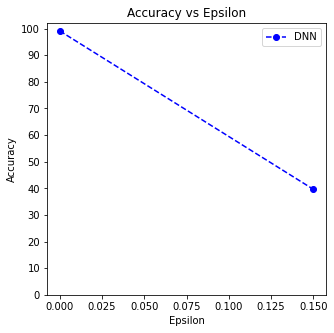

In [27]:
plot_accuracy_vs_epsilon(model2, fgsm_adversarials2)

In [28]:
def get_activations_big_data(model, dataset):
    reshaped_output_layer = []

    for i in neighbours_layers_indexes2: # 0,1,2-convolutions layer, 5-dense layer
        layer = model.layers[i]
        lay_act_arr = []
        chunk_size = 10000
        for i in range(0, 10000, chunk_size):
          lay_act = K.function([model.layers[0].input], [layer.output])([dataset[i:i+chunk_size]])[0]
          lay_act_arr = np.array(lay_act)
        for i in range(10000, len(dataset), chunk_size):
          lay_act = K.function([model.layers[0].input], [layer.output])([dataset[i:i+chunk_size]])[0]
          lay_act_arr = np.append(lay_act_arr, lay_act, axis=0)

        if i != 4:
          reshaped_output_layer.append(lay_act_arr.reshape(lay_act_arr.shape[0], lay_act_arr.shape[1]*lay_act_arr.shape[2]*lay_act_arr.shape[3]))
        else: 
          reshaped_output_layer.append(lay_act_arr)
    
    for layer in reshaped_output_layer:
        layer /= np.linalg.norm(layer, axis=1).reshape(-1, 1)

    return reshaped_output_layer

In [29]:
activations_train2 = get_activations_big_data(model2, x_train)

try: 
  index_act2 = load_pickle('model2/neighbours_index' + ind_neigh + '.pkl')
  print('loaded neighbours index from disc')
except FileNotFoundError:
  print('failed to load neighbours index from disc')
  index_act2 = {}
  for layer in range(knn_layers_count2):
    index_act2[layer] = index_layer(activations_train2[layer])
  # save_pickle(index_act2, 'model2/neighbours_index.pkl')

failed to load neighbours index from disc


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [30]:
# get activations of test set on each layer
activations2 = {}
for eps in epsilons:
  activations2[eps] = get_activations(model2, fgsm_adversarials2[eps], neighbours_layers_indexes2)

try:
  neighbors2 = load_pickle('model2/neighbours' + find_neigh + '.pkl')
  print('loaded neighbours from disc')
except FileNotFoundError:
  print('failed to load neighbours from disc')
  neighbors2 = {}
  for layer in range(knn_layers_count2):
    neighbors2[layer] = {}
    for eps in epsilons:
      neighbors2[layer][eps] = find_neighbours(activations2[eps][layer], index_act2[layer], 0.1)
  # save_pickle(neighbors2, 'model2/neighbours.pkl')

failed to load neighbours from disc


In [31]:
activations_calib2 = get_activations(model2, x_cal, neighbours_layers_indexes2)

neigbours_calib2 = {}
for layer in range(knn_layers_count2):
  neigbours_calib2[layer] = find_neighbours(activations_calib2[layer], index_act2[layer], 0.1)

nonconformity_calib2 = calibrate_nonconformity(neigbours_calib2, knn_layers_count2)

In [32]:
p_values2, knn_predicted_labels2 = calculate_performance_parameters(neighbors2, nonconformity_calib2, knn_layers_count2)

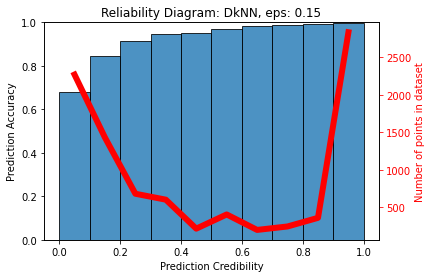

In [33]:
plot_reliability('DkNN', 0.15, p_values2[0.15], knn_predicted_labels2[0.15])

[0.03623594716191292, 0.9911351203918457]
[3.814298152923584, 0.39610812067985535]


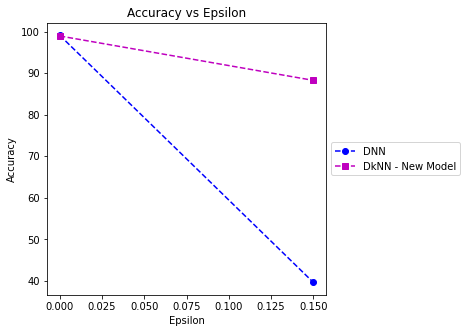

In [34]:
# accuracies_plot_knn = accuracy_per_model(knn_predicted_labels)
# accuracies_plot_knn_annoy = accuracy_per_model(knn_predicted_labels_annoy)
# accuracies_plot_knn_lsh = accuracy_per_model(knn_predicted_labels_lsh)
accuracies_plot_knn_2 = accuracy_per_model(knn_predicted_labels2)

# accuracies_plot_knn = load_pickle('m1_knn.pkl')
# accuracies_plot_knn_lsh = load_pickle('m1_alsh.pkl')
# accuracies_plot_knn_annoy = load_pickle('m1_annoy.pkl')


plot_accuracy_vs_epsilon(model2, fgsm_adversarials2)
# plt.plot(epsilons, accuracies_plot_knn, linestyle='--', marker='*', color='r', label = 'DkNN - PyNND')
# plt.plot(epsilons, accuracies_plot_knn_annoy, linestyle='--', marker='s', color='g', label = 'DkNN - Annoy')
# plt.plot(epsilons, accuracies_plot_knn_lsh, linestyle='--', marker='^', color='c', label = 'DkNN - Falconn')
plt.plot(epsilons, accuracies_plot_knn_2, linestyle='--', marker='s', color='m', label = 'DkNN - New Model')

lgd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('final_graph', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()